<a href="https://colab.research.google.com/github/MpRonald/Machine-Learning/blob/main/NLP_Text_Classification_with_spaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Text Classification eith spaCy

## Step 1: Import and intalling libraries

In [2]:
!python3 -m spacy download pt 

     |████████████████████████████████| 21.2 MB 1.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [3]:
# imports
import pandas as pd
import numpy as np
import string
import spacy
import random
import seaborn as sns

In [4]:
spacy.__version__

'2.2.3'

# Step 2: Loading data Base

In [5]:
data_train = pd.read_csv('https://raw.githubusercontent.com/MpRonald/datasets/main/base_treinamento.txt', encoding='utf-8')

In [6]:
data_train

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria
...,...,...
191,estou chocado e amedrontado com este assassina...,medo
192,é preciso afugenta com ímpeto este medo do inf...,medo
193,políticos usam suas forças para afugentar e am...,medo
194,o objetivo disso e apenas me amedrontar mais,medo


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


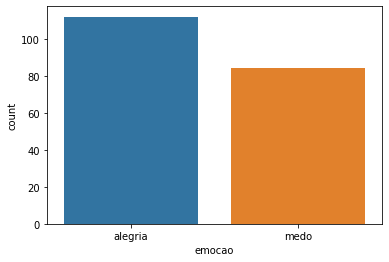

In [7]:
sns.countplot(data_train['emocao'], label='Count');

# Step 3: Function to Text Pre-processing 

In [8]:
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS

In [10]:
len(stop_words)

413

In [11]:
pln = spacy.load("pt")
pln

In [24]:
def pre_processing(text):
    text = text.lower()
    doc = pln(text)
    list_text = []
    for token in doc:
        list_text.append(token.lemma_)
    
    list_text = [word for word in list_text if word not in stop_words and word not in punctuation]
    list_text = ' '.join([str(element) for element in list_text if not element.isdigit()])
    return list_text

In [25]:
test = pre_processing('Em Janelas Privadas com o Tor, o DuckDuckGo é o mecanismo de pesquisa padrão. Alguns dos outros mecanismos de busca populares são mais difíceis de usar com o Tor. O DuckDuckGo não’ rastreia seu histórico de pesquisa; com o Tor, eles não’ sabem nem o seu endereço IP.')
test

'janela privar o tor o duckduckgo o mecanismo pesquisar padrão algum outro mecanismo buscar popular difícil o tor o duckduckgo ’ rastrear histórico pesquisar o tor ’ o endereçar ip'

# Step 4: Data Base pre-processing
## Cleaning Data

In [26]:
data_train['texto'] = data_train['texto'].apply(pre_processing)

In [27]:
data_train.head()

,texto,emocao
0,trabalhar agradável,alegria
1,gostar ficar o aconchegar,alegria
2,o adesão o o cursar hoje,alegria
3,admirar,alegria
4,adorar comer,alegria


## Class Treatment

In [28]:
final_data_train = []
for texto, emocao in zip(data_train['texto'], data_train['emocao']):
    if emocao == 'alegria':
        dic = ({'ALEGRIA':True, 'MEDO':False})
    elif emocao == 'medo':
        dic = ({'ALEGRIA':False, 'MEDO':True})

    final_data_train.append([texto, dic.copy()])

In [29]:
len(final_data_train)

196

In [30]:
final_data_train[0]

['trabalhar agradável', {'ALEGRIA': True, 'MEDO': False}]

In [31]:
final_data_train[0][0]

'trabalhar agradável'

In [32]:
final_data_train[0][1]

{'ALEGRIA': True, 'MEDO': False}

In [33]:
type(final_data_train[0][1])

dict

# Step 5:  Building Classificator

In [34]:
model = spacy.blank('pt')
category = model.create_pipe("textcat")
category.add_label('ALEGRIA')
category.add_label('MEDO')
model.add_pipe(category)
historic = []

In [35]:
model.begin_training()
for epoch in range(1000):
    random.shuffle(final_data_train)
    losses = {}
    for batch in spacy.util.minibatch(final_data_train, 30):
        texts = [model(text) for text, entities in batch]
        annotations = [{'cats': entities} for text, entities in batch]
        model.update(texts, annotations, losses=losses)
    if epoch % 100 == 0:
        print(losses)
        historic.append(losses)

{'textcat': 0.006198364601004869}
{'textcat': 1.6426185034390528e-07}
{'textcat': 4.2162080715613115e-08}
{'textcat': 2.6355177373815764e-08}
{'textcat': 1.0643174563895741e-08}
{'textcat': 6.953488784766648e-09}
{'textcat': 5.560226556955428e-09}
{'textcat': 4.155211258405345e-09}
{'textcat': 3.4340026100476706e-09}
{'textcat': 3.065027565085643e-09}


In [36]:
historic_loss = []
for i in historic:
    historic_loss.append(i.get('textcat'))

In [37]:
historic_loss = np.array(historic_loss)
historic_loss

array([6.19836460e-03, 1.64261850e-07, 4.21620807e-08, 2.63551774e-08,
       1.06431746e-08, 6.95348878e-09, 5.56022656e-09, 4.15521126e-09,
       3.43400261e-09, 3.06502757e-09])

Text(0, 0.5, 'Erroe Value')

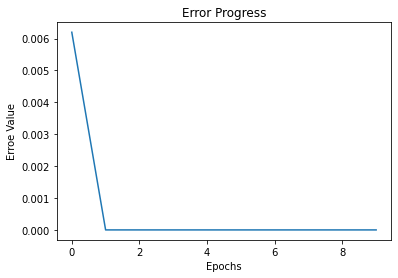

In [38]:
import matplotlib.pyplot as plt
plt.plot(historic_loss)
plt.title("Error Progress")
plt.xlabel("Epochs")
plt.ylabel("Erroe Value")

In [39]:
model.to_disk("model_nlp")

# Step 6: Test Model

In [40]:
model_load = spacy.load('/content/model_nlp')

In [41]:
model_load

In [42]:
positive_text = 'eu amo a cor dos seus olhos'
positive_text = pre_processing(positive_text)
positive_text

'amar o cor olho'

In [43]:
predict = model_load(positive_text)
predict.cats

{'ALEGRIA': 0.9998868703842163, 'MEDO': 4.539786823443137e-05}

In [48]:
negative_text = 'ela tem medo de aranhas'
predict = model_load(pre_processing(negative_text))
predict.cats

{'ALEGRIA': 0.336028516292572, 'MEDO': 0.875439465045929}

# Step 7: Model Evaluation

In [49]:
predictions = []
for text in data_train['texto']:
    predict = model_load(text)
    predictions.append(predict.cats)

In [50]:
final_predictions = []
for predict in predictions:
    if predict['ALEGRIA'] > predict['MEDO']:
        final_predictions.append('alegria')
    else:
        final_predictions.append('medo')

final_predictions = np.array(final_predictions)

In [51]:
real_answers = data_train['emocao'].values

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(real_answers, final_predictions)

1.0

In [53]:
cm = confusion_matrix(real_answers, final_predictions)

In [54]:
cm

array([[112,   0],
       [  0,  84]])

# Validate Model

In [55]:
data_test = pd.read_csv('https://raw.githubusercontent.com/MpRonald/datasets/main/base_teste.txt', encoding='utf-8')
data_test

,texto,emocao
0,não precisei pagar o ingresso,alegria
1,se eu ajeitar tudo fica bem,alegria
2,minha fortuna ultrapassará a sua,alegria
3,sou muito afortunado,alegria
4,é benéfico para todos esta nova medida,alegria
...,...,...
79,fui notificado e estou com medo de perder a gu...,medo
80,estou angustiada com meus filhos na rua,medo
81,e abominável o que fazem com os animais,medo
82,foi terrível o tigre quase o matou,medo


In [56]:
data_test['texto'] = data_test['texto'].apply(pre_processing)
data_test

,texto,emocao
0,precisar pagar o ingressar,alegria
1,ajeitar ficar,alegria
2,fortuna ultrapassar o suar,alegria
3,afortunar,alegria
4,benéfico parir medir,alegria
...,...,...
79,notificar e medo perder o guardar filho,medo
80,angustiar filho o ruir,medo
81,e abominável o o animar,medo
82,terrível o tigre quase o matar,medo


In [57]:
predictions = []
for text in data_test['texto']:
    predict = model_load(text)
    predictions.append(predict.cats)

In [58]:
final_predictions = []
for predict in predictions:
    if predict['ALEGRIA'] > predict['MEDO']:
        final_predictions.append('alegria')
    else:
        final_predictions.append('medo')

final_predictions = np.array(final_predictions)

In [59]:
real_answers = data_test['emocao'].values

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(real_answers, final_predictions)

0.6071428571428571

In [61]:
cm = confusion_matrix(real_answers, final_predictions)

In [62]:
cm

array([[35, 13],
       [20, 16]])